In [94]:
import os 
import requests
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
import datetime
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA
from itertools import combinations, permutations
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Importing data &  preprocessing dataframes

Воспользуемся [https://www.alphavantage.co/documentation/#daily](https://www.alphavantage.co/documentation/#daily) Данное апи не обладает параметров фильтрации по интервалу, поэтому возьмем все данные и фильтранем за последние 10 лет

In [3]:
API_KEY = os.environ.get('STOCKS_API_KEY')

In [4]:
BASE_URL = 'https://www.alphavantage.co/query?function='

In [5]:
def build_params(stock_name: str) -> dict:
    return {'function': 'TIME_SERIES_DAILY',
            'symbol': stock_name,
            "outputsize": "full",
            "apikey": API_KEY
            }

In [6]:
params = {
    "function": "TIME_SERIES_DAILY",
    "symbol": "AAPL",
    "outputsize": "full",
    "apikey": API_KEY
    }

In [7]:
# get data from alphavantage
# APPLE - AAPL, GOOGLE - GOOGL, FACEBOOK - FB
data_apple = requests.get(BASE_URL, params=build_params('AAPL'))
data_google = requests.get(BASE_URL, params=build_params('GOOGL'))
data_facebook = requests.get(BASE_URL, params=build_params('FB'))

In [8]:
# create dicts with structure date: close price
dict_apple_data = {key:value['4. close'] for (key, value) in data_apple.json()['Time Series (Daily)'].items()}
dict_google_data = {key:value['4. close'] for (key, value) in data_google.json()['Time Series (Daily)'].items()}
dict_facebook_data = {key:value['4. close'] for (key, value) in data_facebook.json()['Time Series (Daily)'].items()}

In [9]:
# create pandas dataframe objects from dicts
df_apple = pd.DataFrame.from_dict(dict_apple_data, orient='index', columns=['close'])
df_google = pd.DataFrame.from_dict(dict_google_data, orient='index', columns=['close'])
df_facebook = pd.DataFrame.from_dict(dict_facebook_data, orient='index', columns=['close'])

Посмотрим, как выглядят наши датафреймы для разных акций

In [10]:
df_apple.head()

,close
2021-06-16,130.1500
2021-06-15,129.6400
2021-06-14,130.4800
2021-06-11,127.3500
2021-06-10,126.1100


In [11]:
df_google.head()

,close
2021-06-16,2415.4500
2021-06-15,2428.3900
2021-06-14,2448.9100
2021-06-11,2430.2000
2021-06-10,2435.1300


In [12]:
df_facebook.head()

,close
2021-06-16,331.0800
2021-06-15,336.7500
2021-06-14,336.7700
2021-06-11,331.2600
2021-06-10,332.4600


Выберем данные за последние 10 лет

In [13]:
now = datetime.datetime.now().date()

In [14]:
df_apple.index = pd.to_datetime(df_apple.index)
df_facebook.index = pd.to_datetime(df_facebook.index)
df_google.index = pd.to_datetime(df_google.index)


In [15]:
now = datetime.datetime.now().date()
ten_years_ago = now - datetime.timedelta(days=365.25 * 10 + 2) # todays close price is not available yet

In [16]:
ten_years_ago

datetime.date(2011, 6, 16)

In [17]:
df_apple_10_years = df_apple.loc[now:ten_years_ago]
df_facebook_10_years = df_facebook.loc[now:ten_years_ago]
df_google_10_years = df_google.loc[now:ten_years_ago]

In [18]:
df_apple_10_years['close'] = df_apple_10_years['close'].apply(pd.to_numeric)
df_facebook_10_years['close'] = df_facebook_10_years['close'].apply(pd.to_numeric)
df_google_10_years['close'] = df_google_10_years['close'].apply(pd.to_numeric)

In [19]:
df_apple_10_years

,close
2021-06-16,130.15
2021-06-15,129.64
2021-06-14,130.48
2021-06-11,127.35
2021-06-10,126.11
...,...
2011-06-22,322.61
2011-06-21,325.30
2011-06-20,315.32
2011-06-17,320.26


### Сохраним полученные датафреймы, чтобы каждый раз не прощелкивать

In [20]:
MAPPING = {0: 'apple.csv',
          1: 'facebook.csv',
          2: 'google.csv'}

In [21]:
list_of_dfs = [df_apple_10_years, df_facebook_10_years, df_google_10_years]

In [22]:
for index, df in enumerate(list_of_dfs):
    df.to_csv(MAPPING[index])

In [11]:
df_apple_10_years = pd.read_csv(MAPPING[0], index_col=0)
df_facebook_10_years = pd.read_csv(MAPPING[1], index_col=0)
df_google_10_years = pd.read_csv(MAPPING[2], index_col=0)

## 2. Returns & statistics

In [23]:
df_apple_10_years.loc[:, 'shifted_close'] = df_apple_10_years.shift(1)['close']
df_google_10_years.loc[:, 'shifted_close'] = df_google_10_years.shift(1)['close']
df_facebook_10_years.loc[:,'shifted_close'] = df_facebook_10_years.shift(1)['close']

In [24]:
df_apple_10_years.dtypes

close            float64
shifted_close    float64
dtype: object

In [25]:
for df in list_of_dfs:
    df['return'] = (df['shifted_close'] - df['close']) / df['close']

In [26]:
df_apple_10_years.head()

,close,shifted_close,return
2021-06-16,130.15,NaN,NaN
2021-06-15,129.64,130.15,0.003934
2021-06-14,130.48,129.64,-0.006438
2021-06-11,127.35,130.48,0.024578
2021-06-10,126.11,127.35,0.009833


Очевидно, что у последнего дня выборкии не будет return, потому что следующего дня для нет

In [27]:
df_apple_10_years['return'].describe()

count    2516.000000
mean        0.000471
std         0.028949
min        -0.854857
25%        -0.007328
50%         0.000756
75%         0.010361
max         0.119808
Name: return, dtype: float64

In [28]:
df_facebook_10_years['return'].describe()

count    2283.000000
mean        0.001216
std         0.023386
min        -0.189609
25%        -0.009398
50%         0.001056
75%         0.012331
max         0.296077
Name: return, dtype: float64

Данных по facebook не хватает (не торговались)

In [29]:
df_facebook_10_years.index.min()

Timestamp('2012-05-18 00:00:00')

In [30]:
df_google_10_years['return'].describe()

count    2516.000000
mean        0.000835
std         0.019168
min        -0.496520
25%        -0.006464
50%         0.000945
75%         0.009159
max         0.162584
Name: return, dtype: float64

In [31]:
df_apple_10_years['return'].sort_values()

2014-06-06   -0.854857
2020-08-28   -0.741522
2020-03-13   -0.128647
2013-01-23   -0.123549
2019-01-02   -0.099607
                ...   
2020-02-28    0.093101
2020-03-23    0.100325
2020-07-30    0.104689
2020-03-12    0.119808
2021-06-16         NaN
Name: return, Length: 2517, dtype: float64

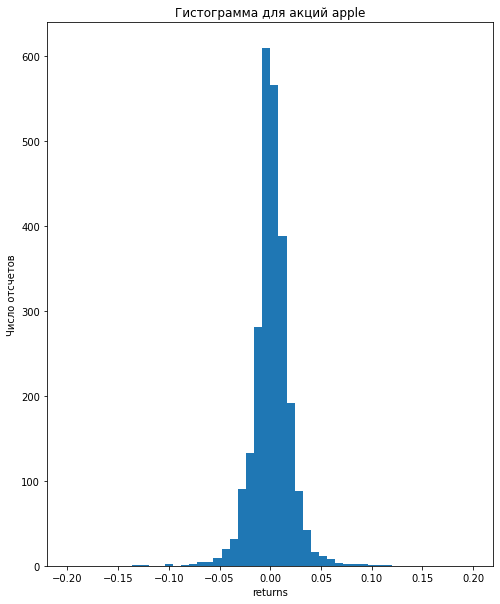

In [32]:
fig = plt.figure(figsize=(8,10))
plt.hist(x=df_apple_10_years['return'], range=(-0.2, 0.2), bins=50)
plt.title('Гистограмма для акций apple')
plt.ylabel('Число отсчетов')
plt.xlabel('returns')
plt.show()

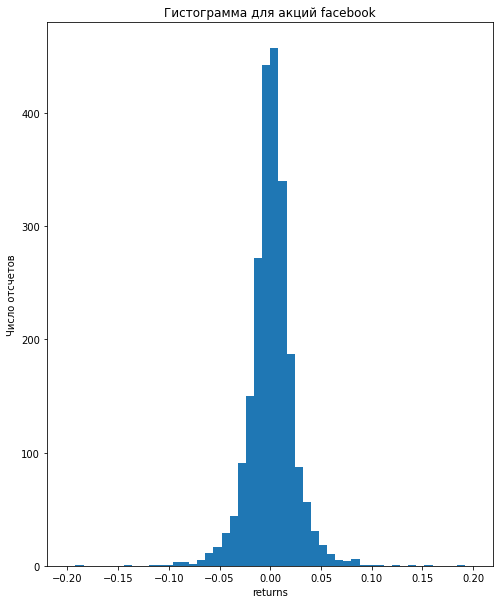

In [33]:
fig = plt.figure(figsize=(8,10))
plt.hist(x=df_facebook_10_years['return'], range=(-0.2, 0.2), bins=50)
plt.title('Гистограмма для акций facebook')
plt.ylabel('Число отсчетов')
plt.xlabel('returns')
plt.show()

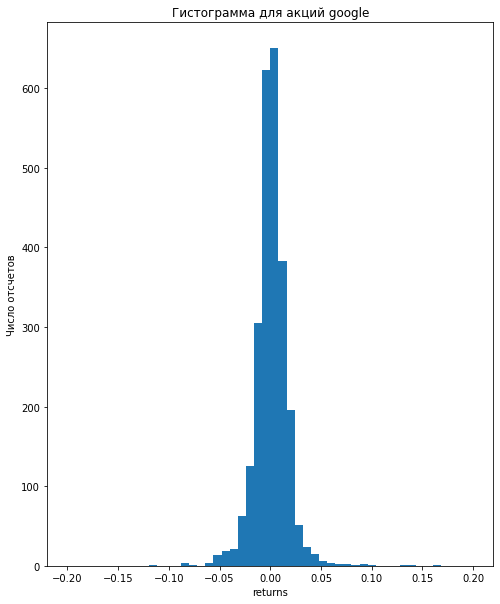

In [34]:
fig = plt.figure(figsize=(8,10))
plt.hist(x=df_google_10_years['return'], range=(-0.2, 0.2), bins=50)
plt.title('Гистограмма для акций google')
plt.ylabel('Число отсчетов')
plt.xlabel('returns')
plt.show()

In [35]:
stats.norm.fit(df_apple_10_years['return'].dropna())

(0.0004710071943360708, 0.028943488232843345)

Отобразим теоретические нормальное и стьюдента распределения. Рассмотрим визуально полученные распределения 

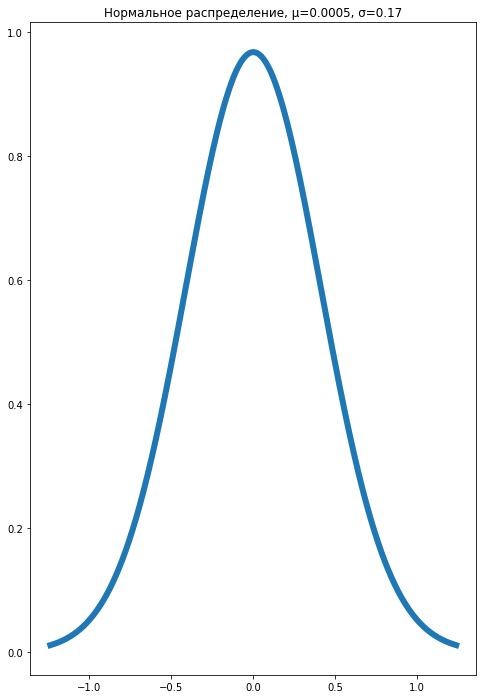

In [37]:
mu = 0.0004675095486357863
variance = 0.17
fig = plt.figure(figsize=(8,12))
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
plt.plot(x, stats.norm.pdf(x, mu, sigma), lw=6)
#plt.xlim((-0.2, 0.2))
#plt.ylim((0, 20))
plt.title('Нормальное распределение, μ=0.0005, σ=0.17')
plt.show()

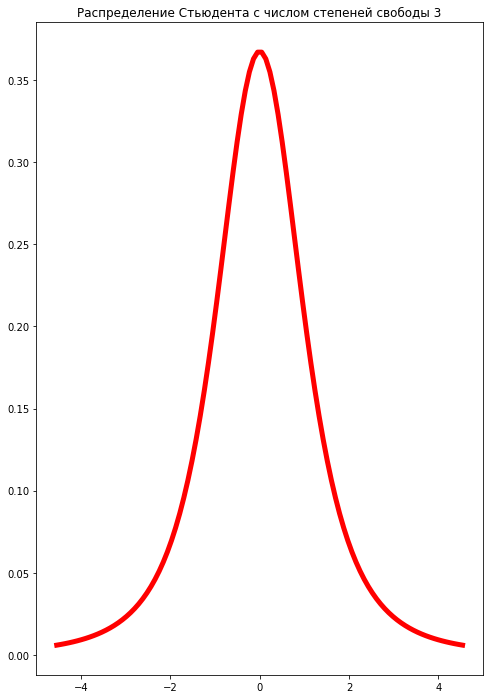

In [38]:
fig = plt.figure(figsize=(8,12))
df=3
x = np.linspace(stats.t.ppf(0.01, df),
                stats.t.ppf(0.99, df), 100)
plt.plot(x, stats.t.pdf(x, df),'r-', lw=5)
plt.title('Распределение Стьюдента с числом степеней свободы 3')
plt.show()

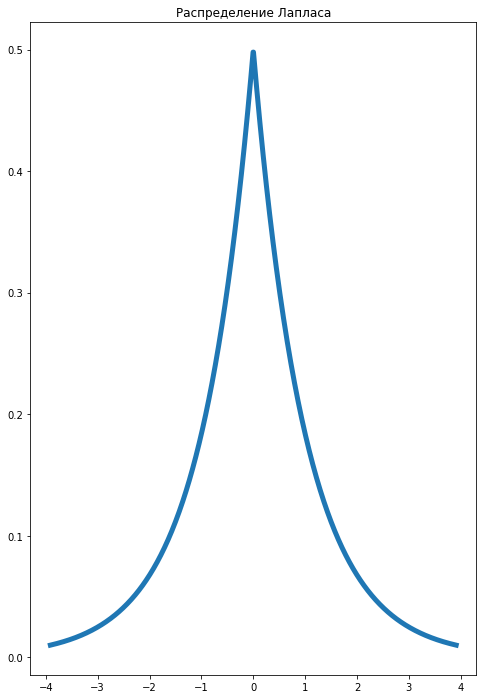

In [39]:
fig = plt.figure(figsize=(8,12))
x = np.linspace(stats.laplace.ppf(0.01),
                stats.laplace.ppf(0.99), 1000)
plt.plot(x, stats.laplace.pdf(x), lw=5)
plt.title('Распределение Лапласа')
plt.show()

Полученные эмперические распределения больше похожи на распределение стьюдента с малым значением степени свободы. Эмперические распределения унимодальны, имеют некую симметрию относитесительно точки (μ,0). Тем ни менее, необходимо проверить строго


Проверим самый простой критерий - графический критерий, связанный с вычислением накопленной частности:
<h2><center>\begin{equation}
W_i=\frac{i - 0.5}{n}, i = \overline{0,n}
\end{equation}</center></h2>
<a href="https://en.wikipedia.org/wiki/Normal_probability_plot">Ссылка на источник</a>

In [40]:
apple_w_df = df_apple_10_years.copy()
google_w_df = df_google_10_years.copy()
facebook_w_df = df_facebook_10_years.copy()

In [41]:
AX_MAPPER = {0: 'Apple',
            1: 'Google',
            2: 'Facebook'}

In [42]:
LIST_OF_DFS = [apple_w_df, google_w_df, facebook_w_df]

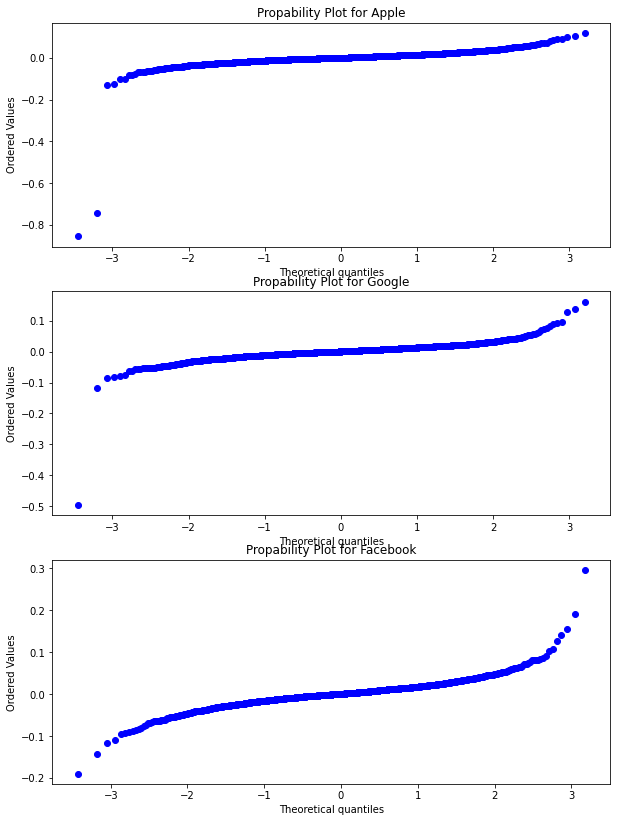

In [43]:
fig, ax = plt.subplots(3,1,figsize=(10,14))
for i, df in enumerate(LIST_OF_DFS):
    stats.probplot(df['return'], dist='norm', plot=ax[i])
    ax[i].set_title(f'Propability Plot for {AX_MAPPER[i]}')
plt.show()

Для нормального распределения ожидается прямая линия, тем ни менее для эмперических данных такое не наблюдается.
Проведем тестирование на симметричность и эксцесс

In [44]:
stats.stats.skewtest(facebook_w_df['return'].dropna())

SkewtestResult(statistic=15.831415155094138, pvalue=1.8892384879832483e-56)

In [45]:
A_apple = stats.stats.skew(apple_w_df['return'].dropna())
A_google = stats.stats.skew(google_w_df['return'].dropna())
A_facebook = stats.stats.skew(facebook_w_df['return'].dropna())

In [46]:
# STD of skew 
D_A_apple = (6 * (len(apple_w_df.dropna()))) / ((len(apple_w_df.dropna()) + 1) * (len(apple_w_df.dropna()) + 3))

In [47]:
np.sqrt(D_A_apple)

0.0487949921034542

In [48]:
print(A_apple, A_google, A_facebook)

-16.955232090222555 -6.5327531470931 0.9465406208233575


Проверим условие:
\begin{equation}\label{eq:2}
\lvert A \rvert\leq 3*\sqrt{D(A)},
\end{equation}
где 
\begin{equation}\label{eq:3}
D(A) = \frac{6 * (n-1)}{(n+2)(n+3)}
\end{equation}




In [49]:
# STD of skew 
D_A_apple = (6 * (len(apple_w_df.dropna()))) / ((len(apple_w_df.dropna()) + 1) * (len(apple_w_df.dropna()) + 3))
print(3 * np.sqrt(D_A_apple))

0.1463849763103626


Видно, что неравенство не выполняется, значит наши распределения "слишком" несимметричны для того, чтобы быть нормальным

In [50]:
print(stats.mstats.normaltest(apple_w_df['return'].dropna())[1], # p-values
     stats.mstats.normaltest(google_w_df['return'].dropna())[1],
     stats.mstats.normaltest(facebook_w_df['return'].dropna())[1])

0.0 0.0 3.0528336174459607e-175


In [51]:
print(stats.shapiro(apple_w_df['return'].dropna())[1],
     stats.shapiro(google_w_df['return'].dropna())[1],
     stats.shapiro(facebook_w_df['return'].dropna())[1])

0.0 0.0 9.790805107911209e-39


In [52]:
jarque_bera_apple = sm.stats.stattools.jarque_bera(apple_w_df['return'].dropna())
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
res_apple = np.vstack([jarque_bera_apple])
print(SimpleTable(res_apple, row))

        JB        p-value         skew             kurtosis     
----------------------------------------------------------------
23592138.83178557     0.0 -16.955232090222555 476.17473517385355
----------------------------------------------------------------


In [53]:
jarque_bera_google = sm.stats.stattools.jarque_bera(google_w_df['return'].dropna())
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
res_google = np.vstack([jarque_bera_google])
print(SimpleTable(res_google, row))

        JB         p-value       skew            kurtosis     
--------------------------------------------------------------
3603533.8224905743     0.0 -6.5327531470931 187.94113679592192
--------------------------------------------------------------


In [54]:
jarque_bera_facebook = sm.stats.stattools.jarque_bera(facebook_w_df['return'].dropna())
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
facebook_res = np.vstack([jarque_bera_facebook])
print(SimpleTable(facebook_res, row))

        JB        p-value        skew             kurtosis     
---------------------------------------------------------------
32739.33595900247     0.0 0.9465406208233575 21.455025735912923
---------------------------------------------------------------


Гипотезы о нормальности распределений могут быть отвергнуты.
Проверим критерием Колмогорова соответствие распределения Стьюдента

In [201]:
print("p-value for google:", stats.stats.kstest(google_w_df['return'].dropna(), stats.t(*stats.t.fit(google_w_df['return'].dropna())).cdf)[1])

p-value for google: 0.8254671153165088


In [202]:
print("p-value for facebook:", stats.stats.kstest(facebook_w_df['return'].dropna(), stats.t(*stats.t.fit(facebook_w_df['return'].dropna())).cdf)[1])

p-value for facebook: 0.6440014099595727


In [204]:
print("p-value for apple:", stats.stats.kstest(apple_w_df['return'].dropna(), stats.t(*stats.t.fit(apple_w_df['return'].dropna())).cdf)[1])

p-value for apple: 0.5128673662371077


При уровне значимости 0.05 можно сделать вывод о том, что распределения return-ов это распределения стьюдента

Проверим стационарность ряда критерием <a href="https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0">Дики-Фуллера</a>

In [56]:
df_apple_10_years_sorted = df_apple_10_years.copy()
df_google_10_years_sorted = df_google_10_years.copy()
df_facebook_10_years_sorted = df_facebook_10_years.copy()

In [57]:
df_apple_10_years_sorted.sort_index(ascending=True, inplace=True)
df_facebook_10_years_sorted.sort_index(ascending=True, inplace=True)
df_google_10_years_sorted.sort_index(ascending=True, inplace=True)


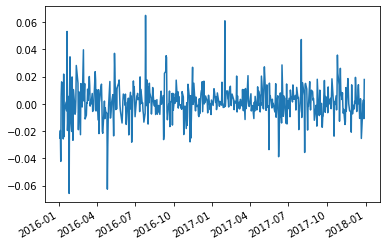

In [58]:
df_apple_10_years_sorted.loc['2016-01-01':'2018-01-01','return'].plot()
plt.show()

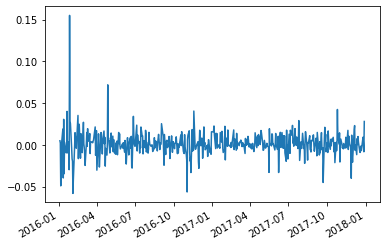

In [59]:
df_facebook_10_years_sorted.loc['2016-01-01':'2018-01-01','return'].plot()
plt.show()

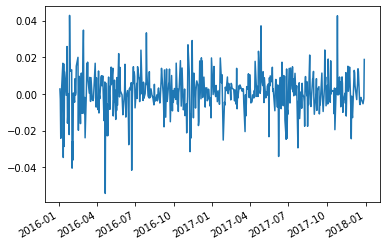

In [60]:
df_google_10_years_sorted.loc['2016-01-01':'2018-01-01','return'].plot()
plt.show()

In [61]:
fuller_test_apple = sm.tsa.adfuller(df_apple_10_years_sorted['return'].dropna())
fuller_test_google = sm.tsa.adfuller(df_google_10_years_sorted['return'].dropna())
fuller_test_facebook = sm.tsa.adfuller(df_facebook_10_years_sorted['return'].dropna())

In [62]:
description = [u'statistic', u'pvalue', u'critical values']

In [63]:
fuller_test_apple

(-52.16134735658533,
 0.0,
 0,
 2515,
 {'1%': -3.4329527780962255,
  '5%': -2.8626898965523724,
  '10%': -2.567382133955709},
 -10547.220637849912)

In [64]:
fuller_test_google

(-18.18988379435541,
 2.420825935426941e-30,
 7,
 2508,
 {'1%': -3.432960050084045,
  '5%': -2.8626931078801285,
  '10%': -2.567383843706519},
 -12654.714711219365)

In [65]:
fuller_test_facebook

(-16.287523959890056,
 3.363862531585112e-29,
 9,
 2273,
 {'1%': -3.4332302025201686,
  '5%': -2.8628124023257175,
  '10%': -2.567447358474132},
 -10621.088977116211)

Нулевая гипотеза заключается в том, что временной ряд имеет единичный корень против альтернативы (нестационарный), что не имеет такого корня, то есть является стационарным. Как видим, значения pvalue близки нулю, поэтому отвергнуть нулевую гипотезу нельзя, следовательно ряды не имеют корней, а значит являются стационарными.

Оценим зависимость между прошлыми и будущими значениями для отдельно выбранной акции, например facebook.
Посчитаем автокорреляцию

In [66]:
df_facebook_10_years_sorted['return'].dropna().autocorr()

-0.030845399160365636

In [67]:
df_facebook_10_years_sorted['return'].dropna().autocorr(lag=10)

-0.04361709747653314

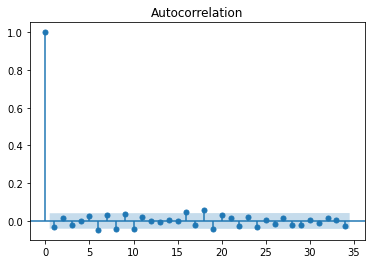

In [68]:
plot_acf(df_facebook_10_years_sorted['return'].dropna())
plt.show()

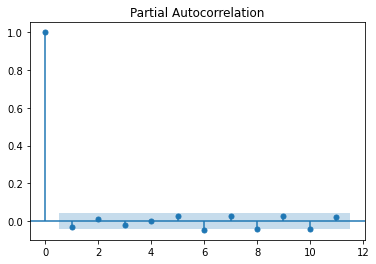

In [69]:
plot_pacf(df_facebook_10_years_sorted['return'].dropna(), lags=11)
plt.show()

Малые значения автокорреляции, которые говорят скорее о том, что не причинности у текущих данных от предыдудщих.
Попробуем формально получить pvalue по критерию Дарбина-Уотсона

In [70]:
test = sm.stats.stattools.durbin_watson(df_facebook_10_years_sorted['return'].dropna())

In [71]:
test

2.0456839001358125

Согласно данным из <a href="https://www3.nd.edu/~wevans1/econ30331/Durbin_Watson_tables.pdf">источника</a> значение данной статистики больше критического значения $d_u$, следовательно, нет статистических доказательств, что есть позитивная автокорреляция. Аналогично, (4-test) > $d_u$, а значит нет и отрицательной автокорреляции. Следовательно, взаимосвязь отсутствуют.

Поищем попарные корелляции между return 3 разных акций на всем периоде (10 лет). Воспользуемся методом Спирмена, так как наши распределения return-ов не обладают нормальностью, а также сразу проверить не только в классе линейных функций, но и в целом монотонных. 

In [114]:
df_apple_10_years_sorted['return'].corr(df_google_10_years_sorted['return'], method='spearman')

0.5037984739744008

In [115]:
df_apple_10_years_sorted['return'].corr(df_facebook_10_years_sorted['return'], method='spearman')

0.42496137881491386

In [116]:
df_google_10_years_sorted['return'].corr(df_facebook_10_years_sorted['return'], method='spearman')

0.5882527070084395

Проведем тест из пакета scipy

In [83]:
test_corr_apple_google = stats.spearmanr(df_apple_10_years_sorted['return'].dropna(), df_google_10_years_sorted['return'].dropna())

In [84]:
test_corr_apple_google

SpearmanrResult(correlation=0.5037984739744008, pvalue=4.66181173097087e-162)

In [88]:
test_corr_apple_facebook = stats.spearmanr(df_apple_10_years_sorted.loc['2012-05-18':, 'return'].dropna(),
                                           df_facebook_10_years_sorted['return'].dropna())

In [89]:
test_corr_apple_facebook

SpearmanrResult(correlation=0.42496137881491386, pvalue=8.719556073101233e-101)

In [90]:
test_corr_google_facebook = stats.spearmanr(df_google_10_years_sorted.loc['2012-05-18':, 'return'].dropna(),
                                           df_facebook_10_years_sorted['return'].dropna())

In [91]:
test_corr_google_facebook

SpearmanrResult(correlation=0.5882527070084395, pvalue=1.2248674172755396e-212)

Нулевая гипотеза заключается в том, что величины не имеют корреляции. Полученные p-value крайне низкие, поэтому с уверенностью можно отвергнуть нулевую гипотезу в пользу альтернативы о том, что данные имеют корреляцию

Посмотрим такую корреляцию, но в более узком диапозоне дат, например 6 месяцев в 2017 году (март-сентябрь)

In [95]:
LIST_OF_DFS_SORTED = [df_apple_10_years_sorted, df_facebook_10_years_sorted, df_google_10_years_sorted]

In [107]:
MAPPER_NAME = {'apple':df_apple_10_years_sorted,
              'facebook': df_facebook_10_years_sorted,
              'google': df_google_10_years_sorted}

In [92]:
test_corr_6_months_apple_facebook = stats.spearmanr(df_apple_10_years_sorted.loc['2017-03-01':'2017-09-02', 'return'],
                                                   df_facebook_10_years_sorted.loc['2017-03-01':'2017-09-02', 'return'])

In [103]:
def get_spearman_corr(df1: pd.DataFrame, df2: pd.DataFrame) -> tuple:
    return stats.spearmanr(df1.loc['2017-03-01':'2017-09-02', 'return'],
                          df2.loc['2017-03-01':'2017-09-02', 'return'])

In [110]:
for name1, name2 in combinations(MAPPER_NAME, 2):
    test = get_spearman_corr(MAPPER_NAME[name1], MAPPER_NAME[name2])
    print(f'{name1} vs {name2}')
    print(f'Spearman correlation coeff: {test[0]}')
    print(f'p-value: {test[1]}')
    print('\n')

apple vs facebook
Spearman correlation coeff: 0.5613267967608461
p-value: 3.731820628759808e-12


apple vs google
Spearman correlation coeff: 0.5193762034166791
p-value: 2.429409429268661e-10


facebook vs google
Spearman correlation coeff: 0.7231970940474403
p-value: 2.56798546588159e-22




Как видно существует весьма "сильная" корреляция между return-нами акций facebook и google.

Рассмотрим Granger causality (причинность по Грэнджеру) - необходимое условие наличия причинности временных рядов. Хотя, исходя из того, что автокорреляции не было обнаружено, то мы обречены на неудачу.

In [128]:
granger_apple_google = pd.DataFrame()
granger_apple_facebook = pd.DataFrame()
granger_facebook_google = pd.DataFrame()

In [129]:
#apple vs google
granger_apple_google['return_apple'] = df_apple_10_years_sorted['return'].dropna()
granger_apple_google['return_google'] = df_google_10_years_sorted['return'].dropna()

# apple vs facebook
granger_apple_facebook['return_apple'] = df_apple_10_years_sorted.loc[df_facebook_10_years_sorted.index.min():, 'return'].dropna()
granger_apple_facebook['return_facebook'] = df_facebook_10_years_sorted['return'].dropna()

# facebook vs google
granger_facebook_google['return_facebook'] = df_facebook_10_years_sorted['return'].dropna()
granger_facebook_google['return_google'] = df_google_10_years_sorted.loc[df_facebook_10_years_sorted.index.min():, 'return'].dropna()

In [123]:
granger_apple_google.head()

,return_apple,return_google
2011-06-16,-0.015070,-0.030677
2011-06-17,-0.015425,-0.000907
2011-06-20,0.031650,0.017376
2011-06-21,-0.008269,-0.012160
2011-06-22,0.026720,-0.013932


In [137]:
sm.tsa.stattools.grangercausalitytests(granger_apple_facebook, 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0064  , p=0.3159  , df_denom=2279, df_num=1
ssr based chi2 test:   chi2=1.0077  , p=0.3155  , df=1
likelihood ratio test: chi2=1.0075  , p=0.3155  , df=1
parameter F test:         F=1.0064  , p=0.3159  , df_denom=2279, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0456  , p=0.3516  , df_denom=2276, df_num=2
ssr based chi2 test:   chi2=2.0959  , p=0.3507  , df=2
likelihood ratio test: chi2=2.0949  , p=0.3508  , df=2
parameter F test:         F=1.0456  , p=0.3516  , df_denom=2276, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8902  , p=0.0342  , df_denom=2273, df_num=3
ssr based chi2 test:   chi2=8.6974  , p=0.0336  , df=3
likelihood ratio test: chi2=8.6808  , p=0.0338  , df=3
parameter F test:         F=2.8902  , p=0.0342  , df_denom=2273, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2149  , p=0.

{1: ({'ssr_ftest': (1.006364662967682, 0.3158818303787218, 2279.0, 1),
   'ssr_chi2test': (1.007689408026437, 0.31545702235227424, 1),
   'lrtest': (1.0074669849091151, 0.31551043668218176, 1),
   'params_ftest': (1.0063646629672336, 0.31588183037872, 2279.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.0456456888498626, 0.3516335876474402, 2276.0, 2),
   'ssr_chi2test': (2.095885603046166, 0.3506583815034255, 2),
   'lrtest': (2.094923295400804, 0.3508271427209377, 2),
   'params_ftest': (1.0456456888501786, 0.35163358764735236, 2276.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.8902206818791263, 0.034231000448208405, 2273.0, 3),
   'ssr_chi2test': (8.697364480445763, 0.03359731923089845, 3),
   'lrtest': (8.680817917334934, 0.033849838079577976, 3),
   'params_ftest': (2.890220681879599, 0.03423100044818314, 2273.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.

In [133]:
sm.tsa.stattools.grangercausalitytests(granger_apple_google, 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6223  , p=0.2029  , df_denom=2512, df_num=1
ssr based chi2 test:   chi2=1.6242  , p=0.2025  , df=1
likelihood ratio test: chi2=1.6237  , p=0.2026  , df=1
parameter F test:         F=1.6223  , p=0.2029  , df_denom=2512, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7986  , p=0.4501  , df_denom=2509, df_num=2
ssr based chi2 test:   chi2=1.6004  , p=0.4492  , df=2
likelihood ratio test: chi2=1.5999  , p=0.4493  , df=2
parameter F test:         F=0.7986  , p=0.4501  , df_denom=2509, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7627  , p=0.5149  , df_denom=2506, df_num=3
ssr based chi2 test:   chi2=2.2944  , p=0.5136  , df=3
likelihood ratio test: chi2=2.2933  , p=0.5138  , df=3
parameter F test:         F=0.7627  , p=0.5149  , df_denom=2506, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5721  , p=0.

{1: ({'ssr_ftest': (1.6222868552298357, 0.20289105034727273, 2512.0, 1),
   'ssr_chi2test': (1.6242242997225464, 0.20250377387498605, 1),
   'lrtest': (1.6237000513501698, 0.20257663909828283, 1),
   'params_ftest': (1.6222868552304766, 0.20289105034721583, 2512.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.7986173112301871, 0.450065019741262, 2509.0, 2),
   'ssr_chi2test': (1.6004176328678281, 0.44923514664093667, 2),
   'lrtest': (1.599908434360259, 0.4493495361351675, 2),
   'params_ftest': (0.7986173112298204, 0.45006501974138735, 2509.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.7626565423814659, 0.5149424921762522, 2506.0, 3),
   'ssr_chi2test': (2.2943606037565325, 0.5136021264160315, 3),
   'lrtest': (2.293313869035046, 0.5138030021923421, 3),
   'params_ftest': (0.7626565423815911, 0.5149424921761457, 2506.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.,

In [134]:
sm.tsa.stattools.grangercausalitytests(granger_facebook_google, 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4449  , p=0.5049  , df_denom=2279, df_num=1
ssr based chi2 test:   chi2=0.4455  , p=0.5045  , df=1
likelihood ratio test: chi2=0.4454  , p=0.5045  , df=1
parameter F test:         F=0.4449  , p=0.5049  , df_denom=2279, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0766  , p=0.9263  , df_denom=2276, df_num=2
ssr based chi2 test:   chi2=0.1535  , p=0.9261  , df=2
likelihood ratio test: chi2=0.1535  , p=0.9261  , df=2
parameter F test:         F=0.0766  , p=0.9263  , df_denom=2276, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5777  , p=0.6296  , df_denom=2273, df_num=3
ssr based chi2 test:   chi2=1.7385  , p=0.6284  , df=3
likelihood ratio test: chi2=1.7378  , p=0.6286  , df=3
parameter F test:         F=0.5777  , p=0.6296  , df_denom=2273, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8721  , p=0.

{1: ({'ssr_ftest': (0.4448672706255688, 0.5048500597374694, 2279.0, 1),
   'ssr_chi2test': (0.4454528791432857, 0.5045022569136521, 1),
   'lrtest': (0.4454094079701463, 0.504523053736542, 1),
   'params_ftest': (0.4448672706260906, 0.5048500597372267, 2279.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.07659112335162133, 0.9262708930281726, 2276.0, 2),
   'ssr_chi2test': (0.15351876306243256, 0.9261126666107194, 2),
   'lrtest': (0.15351359713531565, 0.9261150587290777, 2),
   'params_ftest': (0.07659112335139698, 0.9262708930284066, 2276.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.5777231118806295, 0.6296465411594425, 2273.0, 3),
   'ssr_chi2test': (1.7385068566931394, 0.6284070446575367, 3),
   'lrtest': (1.7378443850757321, 0.6285531560662594, 3),
   'params_ftest': (0.5777231118807143, 0.629646541159331, 2273.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

Формально, мы можем отвергнуть нулевую гипотезу только для акций facebook и google при некоторых значениях сдвига. Формально это подтверждает ту связь, которую мы увидели при нахождении коэффициента корреляции Спирмена. Одновременно с этим отчетливо видно, что нельзя отвергнуть нулевую гипотезу о том, что есть причинная связь между return google от apple.

### 3. profit and loss

In [149]:
# generate random samples (random seed is not set in order to generate not the same samples)
sample1 = np.random.normal(0, 1, len(df_facebook_10_years_sorted))
sample2 = np.random.normal(0, 1, len(df_facebook_10_years_sorted))
sample3 = np.random.normal(0, 1, len(df_facebook_10_years_sorted))

In [148]:
assert ~np.equal(sample1, sample2).all()

In [163]:
index_series = df_facebook_10_years_sorted.index

In [170]:
ts_sample1 = pd.Series(data=sample1, index=index_series,name='f')
ts_sample2= pd.Series(sample2, index=index_series, name='f')
ts_sample3 = pd.Series(sample3, index=index_series, name='f')

In [171]:
pnl_facebook1 = pd.concat([ts_sample1, df_facebook_10_years_sorted['return']], axis=1)
pnl_facebook2 = pd.concat([ts_sample2, df_facebook_10_years_sorted['return']], axis=1)
pnl_facebook3 = pd.concat([ts_sample3, df_facebook_10_years_sorted['return']], axis=1)

In [172]:
pnl_facebook1.dropna(inplace=True)
pnl_facebook2.dropna(inplace=True)
pnl_facebook3.dropna(inplace=True)

In [173]:
pnl_facebook1.head()

,f,return
2012-05-18,1.448797,-0.109903
2012-05-21,-1.501261,-0.089039
2012-05-22,-0.701758,0.032258
2012-05-23,-0.131119,0.032188
2012-05-24,-0.430135,-0.033909


In [174]:
pnl_facebook1['pnl'] = pnl_facebook1['f'] * pnl_facebook1['return']
pnl_facebook2['pnl'] = pnl_facebook2['f'] * pnl_facebook2['return']
pnl_facebook3['pnl'] = pnl_facebook3['f'] * pnl_facebook3['return']

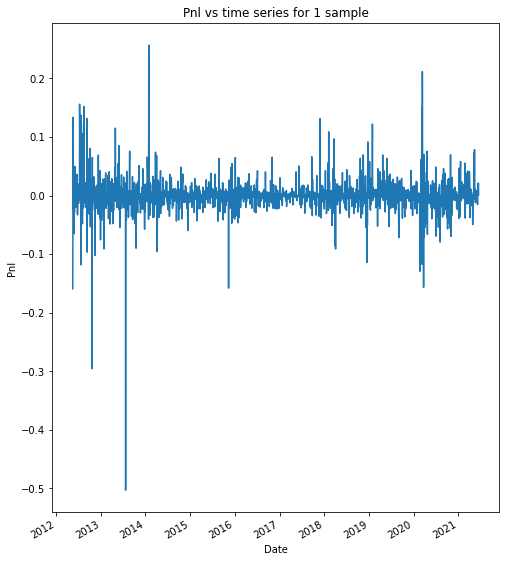

In [183]:
fig = plt.figure(figsize=(8,10))
pnl_facebook1['pnl'].plot()
plt.title('Pnl vs time series for 1 sample')
plt.xlabel('Date')
plt.ylabel('Pnl')
plt.show()

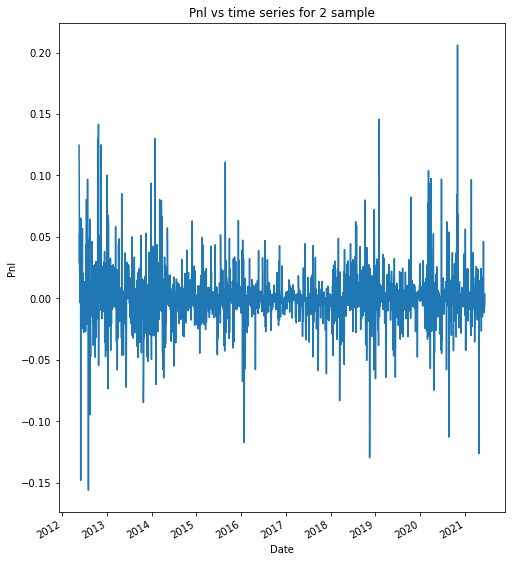

In [184]:
fig = plt.figure(figsize=(8,10))
pnl_facebook2['pnl'].plot()
plt.title('Pnl vs time series for 2 sample')
plt.xlabel('Date')
plt.ylabel('Pnl')
plt.show()

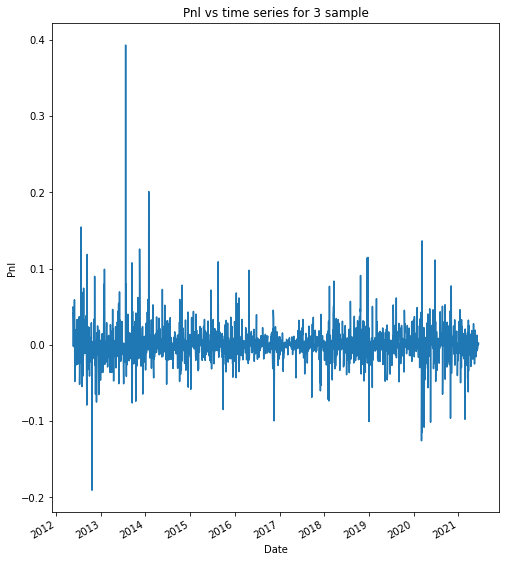

In [186]:
fig = plt.figure(figsize=(8,10))
pnl_facebook3['pnl'].plot()
plt.title('Pnl vs time series for 3 sample')
plt.xlabel('Date')
plt.ylabel('Pnl')
plt.show()

Построим для cumsum pnl

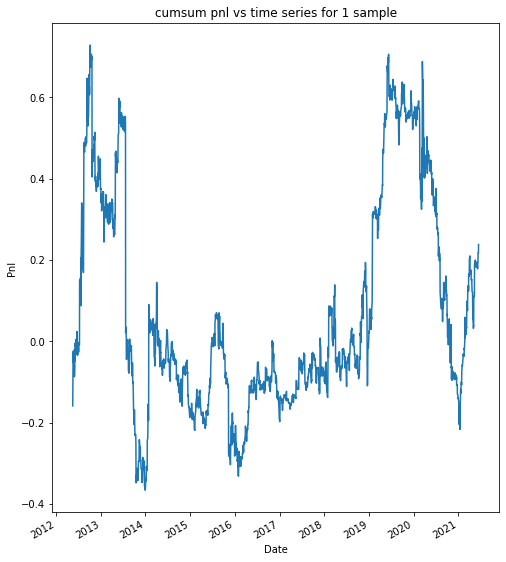

In [188]:
fig = plt.figure(figsize=(8,10))
pnl_facebook1['pnl'].cumsum().plot()
plt.title('cumsum pnl vs time series for 1 sample')
plt.xlabel('Date')
plt.ylabel('Pnl')
plt.show()

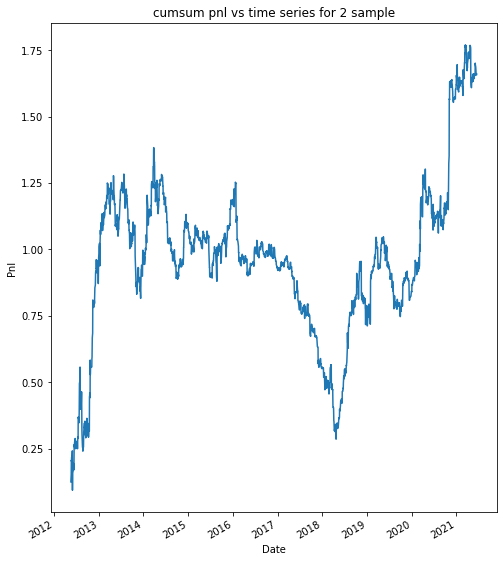

In [189]:
fig = plt.figure(figsize=(8,10))
pnl_facebook2['pnl'].cumsum().plot()
plt.title('cumsum pnl vs time series for 2 sample')
plt.xlabel('Date')
plt.ylabel('Pnl')
plt.show()

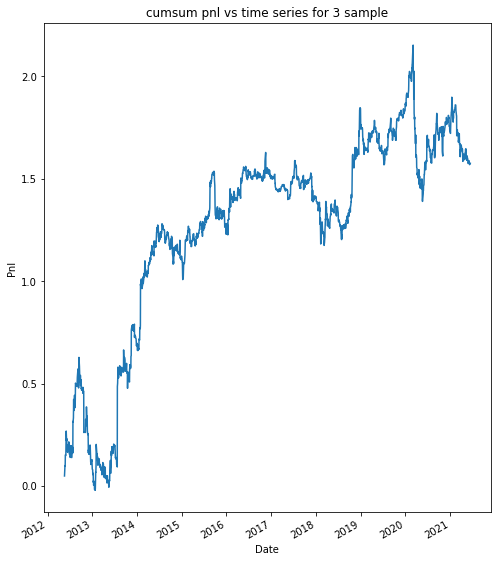

In [190]:
fig = plt.figure(figsize=(8,10))
pnl_facebook3['pnl'].cumsum().plot()
plt.title('cumsum pnl vs time series for 3 sample')
plt.xlabel('Date')
plt.ylabel('Pnl')
plt.show()

### 4. Sharpe ratio

\begin{equation*}\label{eq:4}
SR = E \frac{\left[pnl_i\right]}{\sqrt{V\left[pnl_i\right]}}
\end{equation*}


In [419]:
mu, std = stats.norm.fit(df_google_10_years_sorted['return'])

In [436]:
mu

0.00083514391140145

In [480]:
# Generate many samples (n=10000)
normal_distr = stats.norm(loc=0.0005, scale=0.0289)
N = 10000

In [481]:
df_apple_10_years_sorted.dropna(inplace=True)
df_facebook_10_years_sorted.dropna(inplace=True)
df_google_10_years_sorted.dropna(inplace=True)

In [482]:
normal_distr_apple = normal_distr.rvs((len(df_apple_10_years_sorted), N))
normal_distr_google = normal_distr.rvs((len(df_google_10_years_sorted), N))
normal_distr_facebook = normal_distr.rvs((len(df_facebook_10_years_sorted), N))

In [483]:
normal_distr_apple.shape

(2516, 10000)

In [484]:
# create matrix of return copied N types, so with shape (len(df), N);
returns_apple = np.array([df_apple_10_years_sorted['return'].values] * N).transpose()
returns_facebook =np.array([df_facebook_10_years_sorted['return'].values] * N).transpose()
returns_google = np.array([df_google_10_years_sorted['return'].values] * N).transpose()

In [485]:
returns_facebook.shape

(2283, 10000)

In [486]:
pnl_apple = np.multiply(returns_apple, normal_distr_apple) # element-wise
pnl_google = np.multiply(returns_google, normal_distr_google)
pnl_facebook = np.multiply(returns_facebook, normal_distr_facebook)

In [487]:
pnl_facebook.shape

(2283, 10000)

In [488]:
# matrix (10000 x 1)
SR_apple = pnl_apple.mean(axis=0) / pnl_apple.std(axis=0)
SR_google = pnl_google.mean(axis=0) / pnl_google.std(axis=0)
SR_facebook = pnl_facebook.mean(axis=0) / pnl_facebook.std(axis=0)

In [489]:
SR_apple.shape

(10000,)

In [490]:
HR_apple = np.mean(np.sign(normal_distr_apple) == np.sign(returns_apple), axis=0)
HR_google = np.mean(np.sign(normal_distr_google) == np.sign(returns_google), axis=0)
HR_facebook = np.mean(np.sign(normal_distr_facebook) == np.sign(returns_facebook), axis=0)

In [491]:
HR_apple.shape

(10000,)

In [492]:
MAPPING = {'apple': [HR_apple, SR_apple],
           'google': [HR_google, SR_google],
          'facebook': [HR_facebook, SR_facebook] 
          }

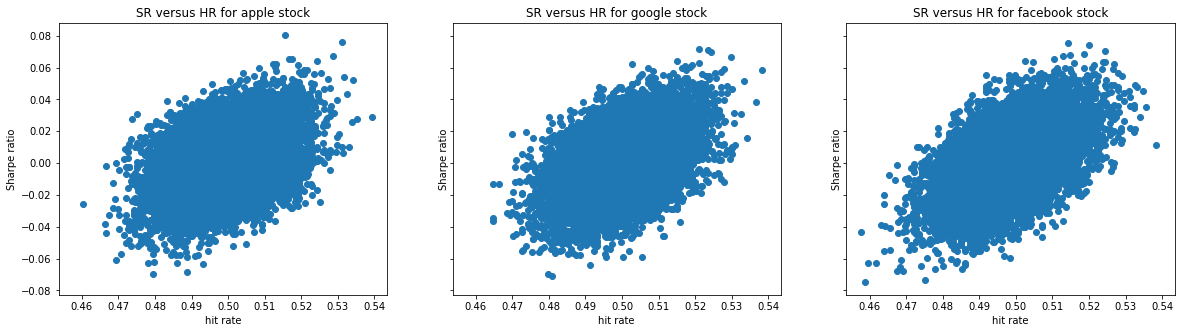

In [493]:
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)
i = 0
for key, value in MAPPING.items():
    axes[i].scatter(x=value[0], y=value[1])
    axes[i].set_title(f'SR versus HR for {key} stock')
    axes[i].set_xlabel('hit rate')
    axes[i].set_ylabel('Sharpe ratio')
    i += 1

Из графиков видно, что прослеживается линейный тренд между коэффициентом Шарпа и hit rate.

### 5. Binary classification

In [969]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [640]:
data = pd.read_csv('xtask.csv')

In [641]:
data.head()

,a,b,c,d,class
0,-0.233408,-0.845698,0.365256,0.311292,1.0
1,0.073524,-0.747284,0.586381,0.303840,1.0
2,0.105561,-0.749805,0.149815,0.635771,1.0
3,-0.642419,-0.342424,-0.608454,0.229135,0.0
4,0.296581,-0.656553,0.022429,0.639708,0.0


In [642]:
data['class'].value_counts()

1.0    2026
0.0    1045
Name: class, dtype: int64

Классы не сбалансированы, но в целом разница в 2 раза.

In [715]:
scaler = StandardScaler()

In [989]:
# separate test data where class is null
X_test = data[data['class'].isna()]

In [990]:
X_test = X_test.drop(columns=['class'])

In [991]:
X_test['a_squared'] = X_test['a'] * X_test['a']
X_test['a_b'] = X_test['a'] / X_test['b']
X_test['d_c'] = X_test['c'] * X_test['d']
X_test['b_squared'] = X_test['b'] * X_test['b']
X_test['d/c'] = X_test['d'] / X_test['c'] 

In [992]:
X_test = StandardScaler().fit_transform(X_test)

In [993]:
X_test.shape

(768, 9)

In [901]:
X_train = data[data['class'].notna()]

In [902]:
y_train = X_train['class']
X_train = X_train.drop(columns=['class'])

In [903]:
# Lets add some new features
X_train['a_squared'] = X_train['a'] * X_train['a']
X_train['a_b'] = X_train['a'] / X_train['b']
X_train['d_c'] = X_train['c'] * X_train['d']
X_train['b_squared'] = X_train['b'] * X_train['b']
X_train['d/c'] = X_train['d'] / X_train['c'] 

In [904]:
X_train = scaler.fit_transform(X_train)

In [995]:
X_train.shape

(3071, 9)

In [906]:
assert X_train.shape[0] + X_test.shape[0] == data.shape[0]

Первым делом проверим линейную зависимость признаков.

In [827]:
data.corr()

,a,b,c,d,class
a,1.000000,-0.008470,-0.002552,-0.001164,-0.006966
b,-0.008470,1.000000,-0.001080,-0.005385,-0.000706
c,-0.002552,-0.001080,1.000000,-0.017755,-0.030994
d,-0.001164,-0.005385,-0.017755,1.000000,-0.003962
class,-0.006966,-0.000706,-0.030994,-0.003962,1.000000


Как видно, признаки достаточно "хорошие" - целевая метка не коррелирует сильно ни с одним из признаков. Сами признаки также не коррелируют. 

Посмотрим шкалы признаков, чтобы определить необходимость стандартизации.

In [593]:
data.describe()

,a,b,c,d,class
count,3839.000000,3839.000000,3839.000000,3839.000000,3071.00000
mean,0.000237,-0.001918,-0.005020,0.017286,0.65972
std,0.492286,0.493000,0.489641,0.504631,0.47388
min,-0.995371,-0.996342,-0.996055,-0.998084,0.00000
25%,-0.394078,-0.395845,-0.395307,-0.386948,0.00000
50%,-0.008509,-0.010900,-0.015388,0.015544,1.00000
75%,0.399061,0.395606,0.382006,0.436341,1.00000
max,0.995987,0.993865,0.988428,0.997183,1.00000


Видно, все признаки лежат от -1 до 1 с примерно одинаковой дисперсией.

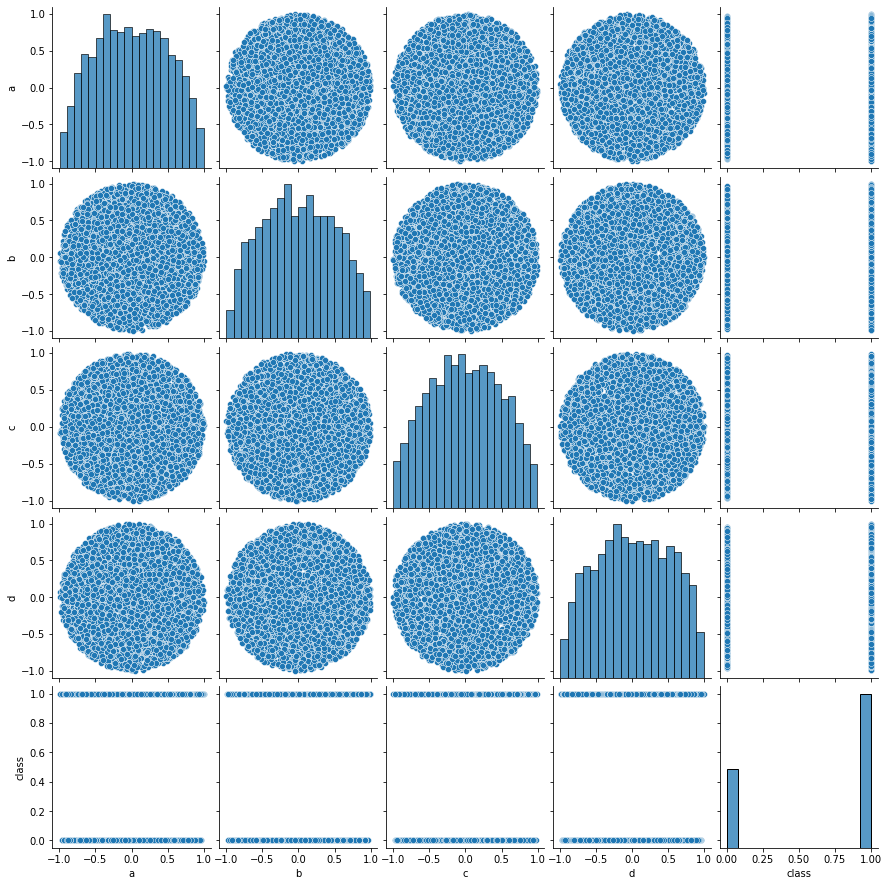

In [594]:
sns.pairplot(data)

Попробуем построить простейшую логистическую регрессию (из коробки sklearn). Валидироваться будем с помощью CV.

In [907]:
logistic = LogisticRegression(multi_class='ovr')

In [908]:
predicted = cross_val_predict(logistic, X_train, y_train, cv=10)

In [909]:
cross_val_score(logistic, X_train, y_train, cv=10, scoring='roc_auc')

array([0.55364767, 0.57550208, 0.56361311, 0.4596438 , 0.52302008,
       0.47835354, 0.55558699, 0.50429043, 0.46982555, 0.5573786 ])

In [910]:
cross_val_score(logistic, X_train, y_train, cv=10).mean()

0.6597201658276577

In [911]:
logistic.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

In [912]:
logistic.coef_

array([[-0.0153983 , -0.00583833, -0.06464491, -0.00758114,  0.0601799 ,
         0.03818196, -0.00400724,  0.12572419,  0.01636331]])

roc-auc в районе 0.5, то есть константое предсказание будет не хуже, чем наше

Используем из коробки xgboost

In [914]:
xgb = XGBClassifier()

In [1014]:
parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.07, 0.09, 0.12, 0.2, 0.11, 0.15],
              'max_depth': [26],
              'silent': [1],
              'subsample': [0.8],
              'n_estimators': [64, 69, 75], 
              'seed': [1337]}


clf = GridSearchCV(xgb, parameters, n_jobs=5, 
                   cv=StratifiedKFold(shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

In [1015]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:   17.4s finished


[21:49:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     miss...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=5,
             para

In [1018]:
clf.best_params_

{'learning_rate': 0.2,
 'max_depth': 26,
 'n_estimators': 75,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 1337,
 'silent': 1,
 'subsample': 0.8}

In [1016]:
clf.best_score_

0.6340359781376115

Попробуем сделать стак моделей.

In [1023]:
stack = StackingClassifier([('rf', RandomForestClassifier(n_estimators=15)),
                           ('xgb_1', XGBClassifier(objective='binary:logistic', max_depth=26, n_estimators=75, learning_rate=0.2)),
                            ('boost', GradientBoostingClassifier(learning_rate=0.15, n_estimators=70)),
                           ('lr', SGDClassifier()),
                           ('knn', KNeighborsClassifier(n_neighbors=4, leaf_size=25)),
                           ('lbm_1', lightgbm.LGBMClassifier(num_leaves=70 , learning_rate=0.07, objective='binary', metric='roc_auc'))],
                          final_estimator=LogisticRegression(solver='liblinear', max_iter=400), n_jobs=3)

In [ ]:
#('boost', GradientBoostingClassifier(learning_rate=0.09, n_estimators=70)

In [999]:
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [1026]:
stack.fit(X_train_train, y_train_train).score(X_val, y_val)

0.6780487804878049

In [1027]:
cross_val_score(stack, X_train, y_train, cv=10, scoring='roc_auc').mean()

0.6580556749579575

In [1005]:
#final fit
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=15)),
                               ('boost',
                                GradientBoostingClassifier(learning_rate=0.09,
                                                           n_estimators=70)),
                               ('xgb_1',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learn...
                                              reg_lambda=None,
                                              scale_pos_weigh

In [1006]:
predicted_test = stack.predict(X_test)

In [1007]:
predicted_test

array([1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1.

In [1010]:
res_out = [str(item) for item in predicted_test]

In [1011]:
with open('res.txt', 'w') as file:
    file.write('\n'.join(res_out))